In [ ]:
import json
import os
import shutil
import uuid
from datetime import datetime
from pathlib import Path
from pprint import pprint

from tqdm.auto import tqdm

from .. import evaluate, inference

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["nnUNet_def_n_proc"] = "4"
# os.environ["OMP_NUM_THREADS"] = "1"
MODEL_OUT_PATH = Path("./tmp/predictions")
EVAL_OUT_PATH = Path("./tmp/output")

SAM2_CHECKPOINT = Path(
    "/rodata/mnradonc_dev/m299164/trackrad/trackrad-model/resources/sam2.1_hiera_small_trackrad_07_21.pt"
)
NN_UNET_MODEL_FOLDER = Path(
    "/rodata/mnradonc_dev/m299164/trackrad/trackrad-model/resources/nnunet-model"
)
FOLD = "all"
NNUNET_FOLDS = (FOLD,)
# INPUT_PATH = Path(
#     f"/rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold{FOLD}"
# )
INPUT_PATH = Path(
    "/rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-labeled-eval"
)


RECALC_BASELINE = True
CALC_REFINED = True
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [2]:
shutil.rmtree("./tmp", ignore_errors=True)


def prediction_json(
    cohort: str, job_id: str, case_id: str, start_time: str, end_time: str
) -> str:
    return json.dumps(
        {
            "pk": job_id,
            "ground_truth_directory": str(INPUT_PATH),
            "input_directory": str(MODEL_OUT_PATH / cohort),
            "output_directory": str(EVAL_OUT_PATH / cohort),
            "inputs": [
                {"value": 8, "interface": {"slug": "frame-rate"}},
                {"value": 1.5, "interface": {"slug": "magnetic-field-strength"}},
                {"value": "abdomen", "interface": {"slug": "scanned-region"}},
                {
                    "image": {"name": "mri-linac-target.mha"},
                    "interface": {
                        "slug": "mri-linac-target",
                        "relative_path": "images/mri-linac-target",
                    },
                },
                {
                    "image": {"name": f"{case_id}.mha"},
                    "interface": {
                        "slug": "mri-linac-series",
                        "relative_path": "images/mri-linacs",
                    },
                },
            ],
            "status": "Succeeded",
            "outputs": [
                {
                    "image": {"name": "output.mha"},
                    "interface": {
                        "slug": "mri-linac-series-targets",
                        "relative_path": "images/mri-linac-series-targets",
                    },
                }
            ],
            "started_at": start_time,
            "completed_at": end_time,
        }
    )

In [3]:
os.environ["TQDM_DISABLE"] = "1"


def do_inference(cohort: str, do_refinement: bool):
    for case_folder in tqdm(list(INPUT_PATH.iterdir())):
        if not case_folder.is_dir():
            continue

        print(f"Processing case: {case_folder}")

        job_id = str(uuid.uuid4())
        output_path = MODEL_OUT_PATH / cohort / job_id / "output"

        start_time = datetime.now().isoformat()
        inference.run(
            case_folder,
            output_path,
            sam2_checkpoint=SAM2_CHECKPOINT,
            nnunet_model_folder=NN_UNET_MODEL_FOLDER,
            nnunet_folds=NNUNET_FOLDS,
            do_refinement=do_refinement,
        )
        end_time = datetime.now().isoformat()

        json_file = output_path / "prediction.json"
        json_file.parent.mkdir(parents=True, exist_ok=True)
        json_file.touch(exist_ok=True)
        with open(json_file, "w") as f:
            f.write(
                prediction_json(
                    cohort,
                    job_id,
                    case_folder.name,
                    start_time,
                    end_time,
                )
            )


if RECALC_BASELINE:
    do_inference("baseline", do_refinement=False)
    for case_folder in Path("./tmp").iterdir():
        if case_folder.is_dir() and case_folder.name[1] == "_":
            dest = Path("./tmp/annots/baseline") / case_folder.name
            dest.mkdir(parents=True, exist_ok=True)
            shutil.copytree(case_folder, dest, dirs_exist_ok=True)
if CALC_REFINED:
    do_inference("refined", do_refinement=True)
    for case_folder in Path("./tmp").iterdir():
        if case_folder.is_dir() and case_folder.name[1] == "_":
            dest = Path("./tmp/annots/refined") / case_folder.name
            dest.mkdir(parents=True, exist_ok=True)
            shutil.copytree(case_folder, dest, dirs_exist_ok=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_016
Runtime loading:   4.66663 s


frame loading (JPEG): 100%|██████████| 169/169 [00:03<00:00, 45.11it/s]
/rodata/mnradonc_dev/m299164/trackrad/trackrad-model/.venv/lib/python3.11/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/rodata/mnradonc_dev/m299164/trackrad/trackrad-model/.venv/lib/python3.11/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 169/169 [00:03<00:00, 48.46it/s]


Runtime algorithm: 8.96753 s
Runtime writing:   0.01230 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/C_009
Runtime loading:   1.78119 s


propagate in video: 100%|██████████| 47/47 [00:00<00:00, 47.26it/s]


Runtime algorithm: 2.76806 s
Runtime writing:   0.01134 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_017
Runtime loading:   1.72136 s


propagate in video: 100%|██████████| 72/72 [00:01<00:00, 47.04it/s]


Runtime algorithm: 4.36092 s
Runtime writing:   0.01316 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/C_005
Runtime loading:   1.98379 s


propagate in video: 100%|██████████| 47/47 [00:00<00:00, 48.39it/s]


Runtime algorithm: 2.73903 s
Runtime writing:   0.00877 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_028
Runtime loading:   1.67691 s


propagate in video: 100%|██████████| 100/100 [00:02<00:00, 48.35it/s]


Runtime algorithm: 5.61721 s
Runtime writing:   0.00877 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_011
Runtime loading:   1.75586 s


propagate in video: 100%|██████████| 107/107 [00:02<00:00, 47.22it/s]


Runtime algorithm: 6.35807 s
Runtime writing:   0.01538 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_019
Runtime loading:   1.71306 s


propagate in video: 100%|██████████| 72/72 [00:01<00:00, 47.17it/s]


Runtime algorithm: 4.60928 s
Runtime writing:   0.01474 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_025
Runtime loading:   1.61182 s


propagate in video: 100%|██████████| 97/97 [00:02<00:00, 45.52it/s]


Runtime algorithm: 5.94167 s
Runtime writing:   0.01491 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_027
Runtime loading:   1.60623 s


propagate in video: 100%|██████████| 100/100 [00:02<00:00, 48.38it/s]


Runtime algorithm: 5.16404 s
Runtime writing:   0.00794 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_010
Runtime loading:   1.71664 s


propagate in video: 100%|██████████| 93/93 [00:01<00:00, 47.87it/s]


Runtime algorithm: 5.32041 s
Runtime writing:   0.01213 s


  0%|          | 0/10 [00:00<?, ?it/s]

Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_016
Runtime loading:   1.41662 s


propagate in video: 100%|██████████| 169/169 [00:03<00:00, 44.39it/s]


Refining masks with nnUNet:   0%|          | 0/169 [00:00<?, ?it/s]

Runtime algorithm: 27.52289 s
Runtime writing:   0.01561 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/C_009
Runtime loading:   1.74526 s


propagate in video: 100%|██████████| 47/47 [00:00<00:00, 48.99it/s]


Refining masks with nnUNet:   0%|          | 0/47 [00:00<?, ?it/s]

Runtime algorithm: 15.14732 s
Runtime writing:   0.00943 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_017
Runtime loading:   1.48037 s


propagate in video: 100%|██████████| 72/72 [00:01<00:00, 45.42it/s]


Refining masks with nnUNet:   0%|          | 0/72 [00:00<?, ?it/s]

Runtime algorithm: 12.97445 s
Runtime writing:   0.01360 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/C_005
Runtime loading:   1.58687 s


propagate in video: 100%|██████████| 47/47 [00:01<00:00, 46.16it/s]


Refining masks with nnUNet:   0%|          | 0/47 [00:00<?, ?it/s]

Runtime algorithm: 17.20300 s
Runtime writing:   0.01186 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_028
Runtime loading:   1.62301 s


propagate in video: 100%|██████████| 100/100 [00:02<00:00, 43.63it/s]


Refining masks with nnUNet:   0%|          | 0/100 [00:00<?, ?it/s]

Runtime algorithm: 15.36235 s
Runtime writing:   0.01294 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_011
Runtime loading:   2.14766 s


propagate in video: 100%|██████████| 107/107 [00:02<00:00, 44.85it/s]


Refining masks with nnUNet:   0%|          | 0/107 [00:00<?, ?it/s]

Runtime algorithm: 16.93596 s
Runtime writing:   0.01461 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_019
Runtime loading:   1.54537 s


propagate in video: 100%|██████████| 72/72 [00:01<00:00, 44.47it/s]


Refining masks with nnUNet:   0%|          | 0/72 [00:00<?, ?it/s]

Runtime algorithm: 13.96872 s
Runtime writing:   0.01322 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_025
Runtime loading:   1.54463 s


propagate in video: 100%|██████████| 97/97 [00:02<00:00, 44.43it/s]


Refining masks with nnUNet:   0%|          | 0/97 [00:00<?, ?it/s]

Runtime algorithm: 27.64278 s
Runtime writing:   0.01386 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/A_027
Runtime loading:   1.70662 s


propagate in video: 100%|██████████| 100/100 [00:02<00:00, 47.47it/s]


Refining masks with nnUNet:   0%|          | 0/100 [00:00<?, ?it/s]

Runtime algorithm: 15.10819 s
Runtime writing:   0.01460 s
Processing case: /rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad-eval-fold0/B_010
Runtime loading:   1.59588 s


propagate in video: 100%|██████████| 93/93 [00:02<00:00, 44.41it/s]


Refining masks with nnUNet:   0%|          | 0/93 [00:00<?, ?it/s]

Runtime algorithm: 26.45309 s
Runtime writing:   0.01401 s


In [4]:
for model_out_path in [MODEL_OUT_PATH / "baseline", MODEL_OUT_PATH / "refined"]:
    predictions = []
    for json_file in model_out_path.rglob("*.json"):
        with json_file.open("r") as infile:
            content = json.loads(infile.read().strip())
            if content:
                predictions.append(content)

    output_file = model_out_path / "predictions.json"
    with output_file.open("w") as outfile:
        json.dump(predictions, outfile)

    eval_out_path = EVAL_OUT_PATH / model_out_path.name
    eval_out_path.mkdir(parents=True, exist_ok=True)
    evaluate.main(input_directory=model_out_path, output_directory=eval_out_path)

Input Files:
['tmp/predictions/baseline/predictions.json',
 'tmp/predictions/baseline/60bfa326-3450-4e30-85ad-ffee332b822a/output/prediction.json',
 'tmp/predictions/baseline/60bfa326-3450-4e30-85ad-ffee332b822a/output/images/mri-linac-series-targets/output.mha',
 'tmp/predictions/baseline/6d341433-d733-499d-bfd1-10759015abc0/output/prediction.json',
 'tmp/predictions/baseline/6d341433-d733-499d-bfd1-10759015abc0/output/images/mri-linac-series-targets/output.mha',
 'tmp/predictions/baseline/4ffdf852-eb65-466e-bd0e-631a2950f2da/output/prediction.json',
 'tmp/predictions/baseline/4ffdf852-eb65-466e-bd0e-631a2950f2da/output/images/mri-linac-series-targets/output.mha',
 'tmp/predictions/baseline/491048dd-526c-4e7c-95d6-ffda5cc3e239/output/prediction.json',
 'tmp/predictions/baseline/491048dd-526c-4e7c-95d6-ffda5cc3e239/output/images/mri-linac-series-targets/output.mha',
 'tmp/predictions/baseline/1592546a-710e-472f-bd81-df8ac6006334/output/prediction.json',
 'tmp/predictions/baseline/15925

In [5]:
baseline_metrics_file = EVAL_OUT_PATH / "baseline" / "metrics.json"
with baseline_metrics_file.open("r") as f:
    baseline_metrics = json.load(f)
print("baseline:")
pprint(baseline_metrics["aggregates"])

refined_metrics_file = EVAL_OUT_PATH / "refined" / "metrics.json"
with refined_metrics_file.open("r") as f:
    refined_metrics = json.load(f)
print()
print("refined:")
pprint(refined_metrics["aggregates"])

baseline_dice = {
    r["case_id"]: r["dice_similarity_coefficient"] for r in baseline_metrics["results"]
}
refined_dice = {
    r["case_id"]: r["dice_similarity_coefficient"] for r in refined_metrics["results"]
}

dices = {
    case_id: {"baseline": baseline_dice[case_id], "refined": refined_dice[case_id]}
    for case_id in baseline_dice.keys()
}

sorted_dice = sorted(
    dices.items(), key=lambda x: x[1]["refined"]
)  # Get the case with the minimum dice similarity coefficient

baseline:
{'center_distance': 1.433437387333458,
 'dice_similarity_coefficient': 0.9182988026385595,
 'hausdorff_distance_95': 3.89067175233872,
 'loading_time': 0.910544369677696,
 'relative_d98_dose': 0.9414217616191904,
 'runtime': 6.323057930322304,
 'surface_distance_average': 1.323597219801068,
 'time_per_frame': 0.06994533108763612,
 'total_time': 72.336023}

refined:
{'center_distance': 1.3435273576798759,
 'dice_similarity_coefficient': 0.9168786829918701,
 'hausdorff_distance_95': 3.5379224103231026,
 'loading_time': 11.704576879019797,
 'relative_d98_dose': 0.9755612878787879,
 'runtime': 8.786505520980203,
 'surface_distance_average': 1.2649223112853518,
 'time_per_frame': 0.09719585753296682,
 'total_time': 204.91082400000002}


In [6]:
# after = {
#     "center_distance": 1.3046445819475643,
#     "dice_similarity_coefficient": 0.920104286178238,
#     "hausdorff_distance_95": 3.1441829912556383,
#     "loading_time": 1.8490781539150303,
#     "relative_d98_dose": 0.9677078721474955,
#     "runtime": 5.5294807060849696,
#     "surface_distance_average": 1.1402019564120371,
#     "time_per_frame": 0.054997818839118445,
#     "total_time": 368.927943,
# }

# before = {
#     "center_distance": 1.3313475618149924,
#     "dice_similarity_coefficient": 0.9186995586692427,
#     "hausdorff_distance_95": 3.2305672318119276,
#     "loading_time": 1.7498454130518974,
#     "relative_d98_dose": 0.9613066590962253,
#     "runtime": 5.658172566948103,
#     "surface_distance_average": 1.1612007734907186,
#     "time_per_frame": 0.05627782541225483,
#     "total_time": 370.4008989999999,
# }

# %matplotlib inline
# import matplotlib.pyplot as plt

# metrics_to_plot = [
#     "dice_similarity_coefficient",
#     "center_distance",
#     "hausdorff_distance_95",
#     "surface_distance_average",
#     "relative_d98_dose",
# ]

# changes = [(before[m] - after[m]) / before[m] for m in metrics_to_plot]
# changes[0] = -changes[0]
# changes[4] = -changes[4]

# plt.figure(figsize=(8, 4))
# bars = plt.bar(metrics_to_plot, changes)
# plt.ylabel("Change (After - Before)")
# plt.title("Metric Change After vs Before")
# plt.axhline(0, color="gray", linestyle="--", linewidth=1)
# plt.xticks(rotation=30, ha="right")
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_675163/504454019.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y * 100:.1f}%" for y in ax.get_yticks()])


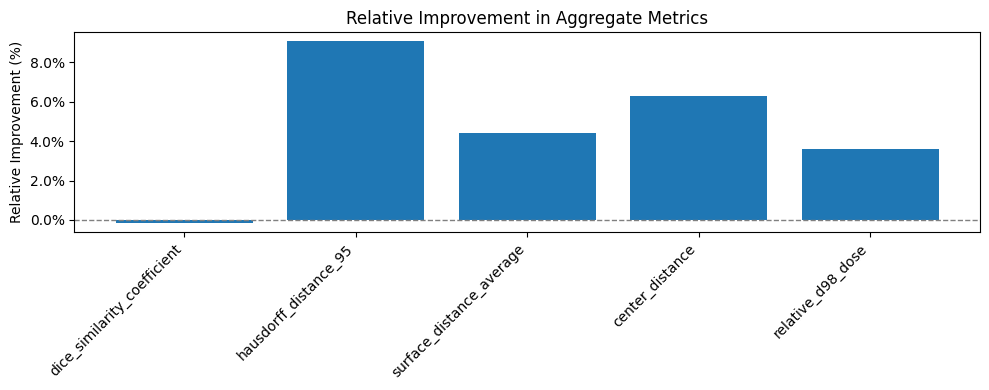

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

metrics_change = {
    k: (baseline_metrics["aggregates"][k] - refined_metrics["aggregates"][k])
    / baseline_metrics["aggregates"][k]
    for k in baseline_metrics["aggregates"].keys()
    if k not in {"runtime", "loading_time", "total_time", "time_per_frame"}
}

metrics_change["dice_similarity_coefficient"] = -metrics_change[
    "dice_similarity_coefficient"
]
metrics_change["relative_d98_dose"] = -metrics_change["relative_d98_dose"]
metric_names, changes = zip(*[(k, v) for k, v in metrics_change.items()])

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(metric_names, changes)
ax.set_ylabel("Relative Improvement")
ax.set_title("Relative Improvement in Aggregate Metrics")
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.set_ylabel("Relative Improvement (%)")
ax.set_yticklabels([f"{y * 100:.1f}%" for y in ax.get_yticks()])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

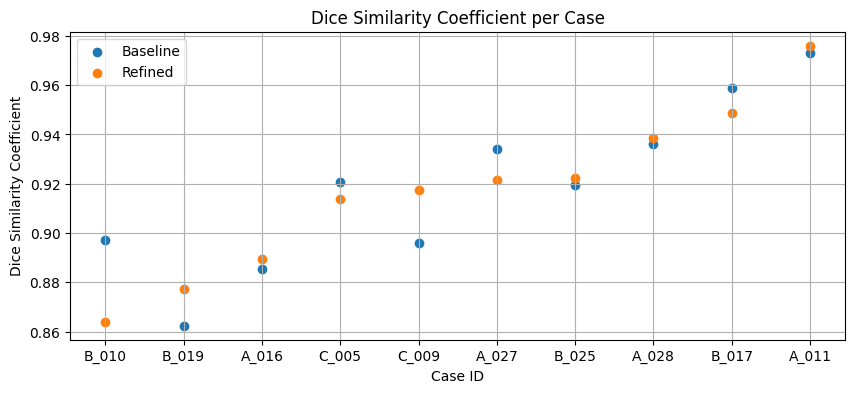

In [8]:
import matplotlib.pyplot as plt

case_ids, dice_scores = zip(*sorted_dice)
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(case_ids, [d["baseline"] for d in dice_scores], label="Baseline")
ax.scatter(case_ids, [d["refined"] for d in dice_scores], label="Refined")
ax.set_ylabel("Dice Similarity Coefficient")
ax.set_xlabel("Case ID")
ax.set_title("Dice Similarity Coefficient per Case")
ax.legend()
ax.grid(True)


B_010


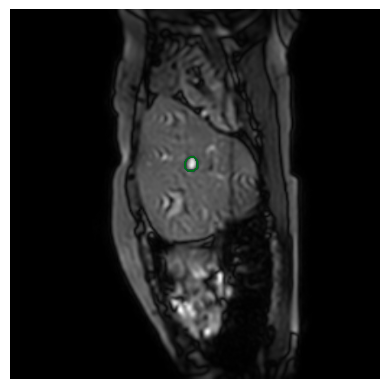

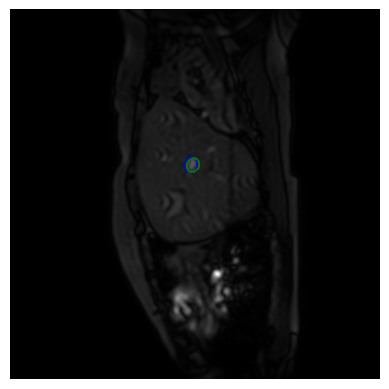

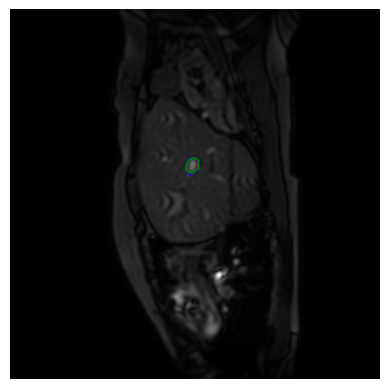

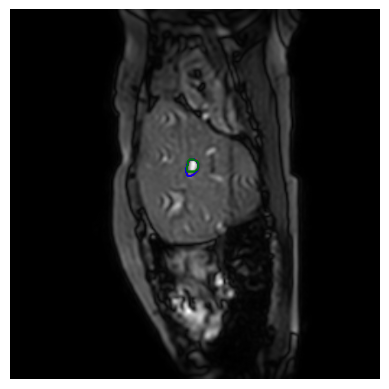

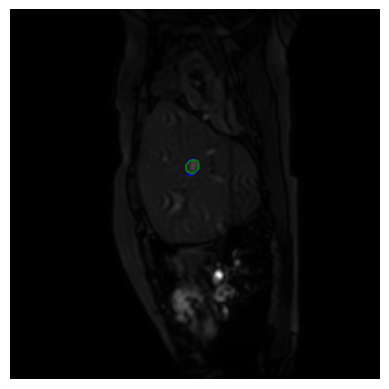

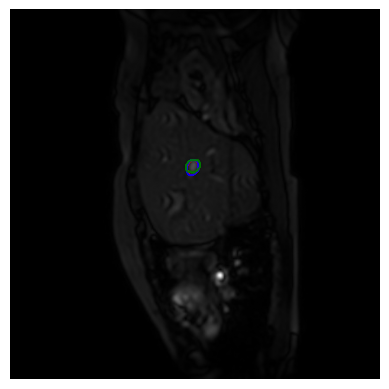

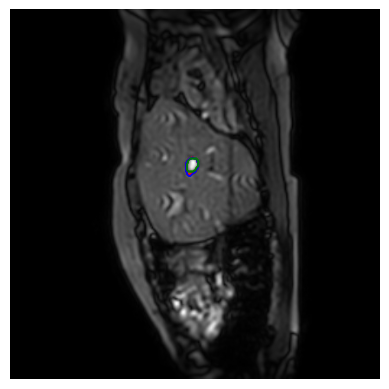

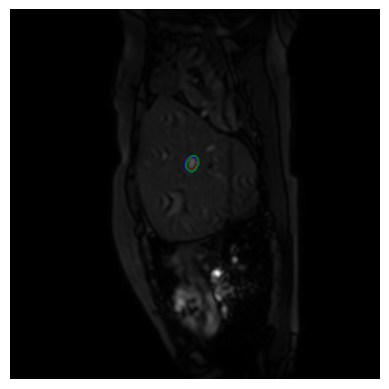

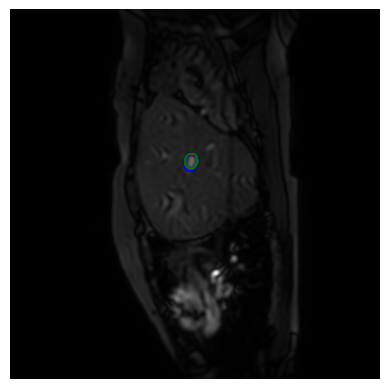

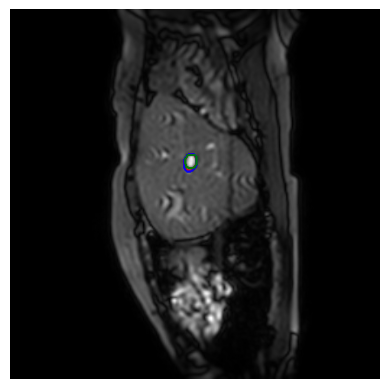

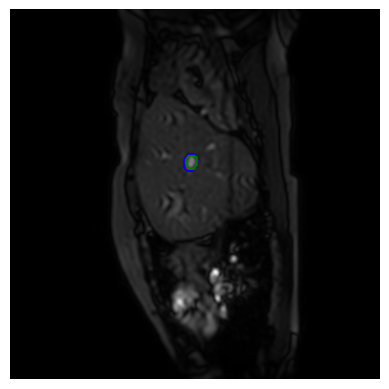

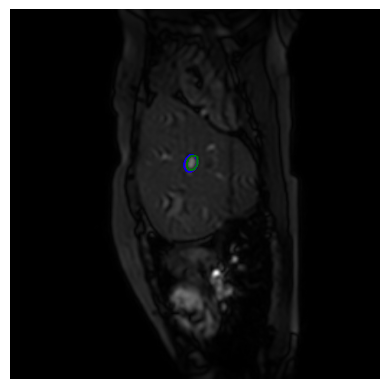

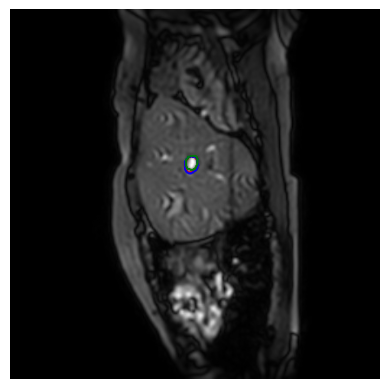

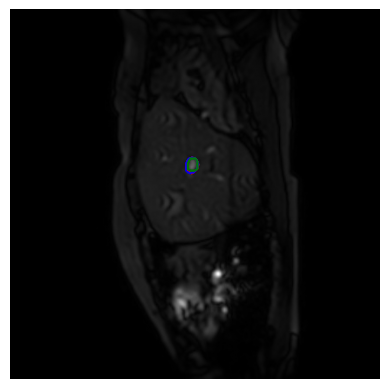

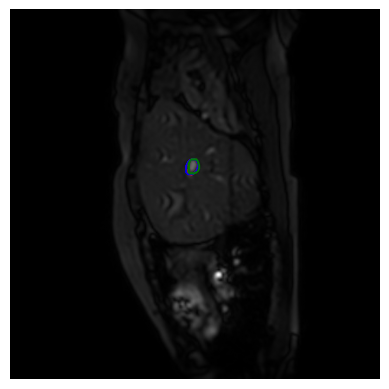

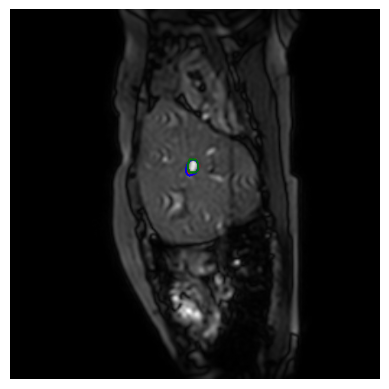

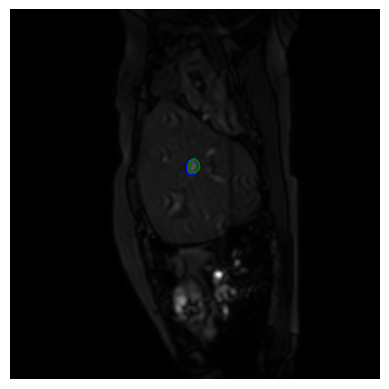

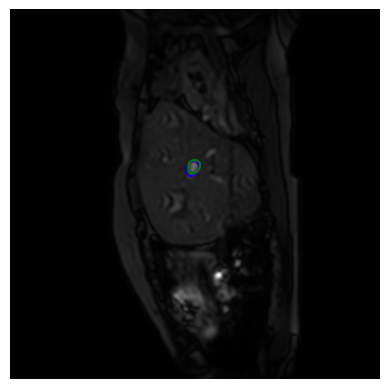

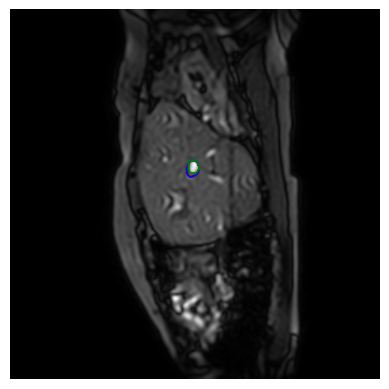

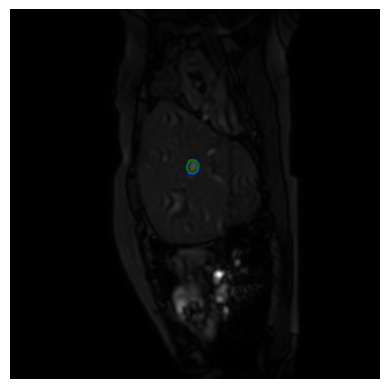

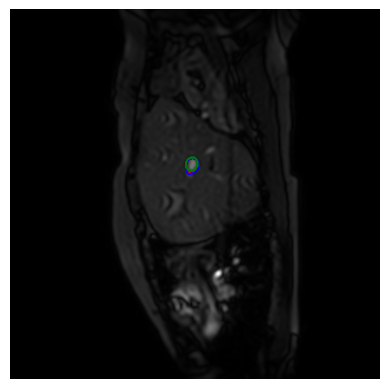

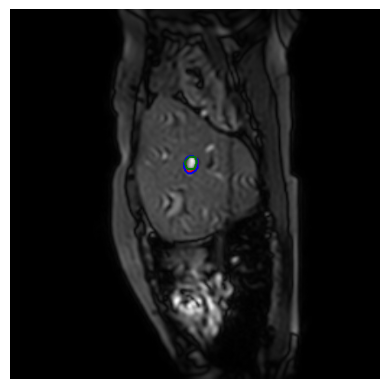

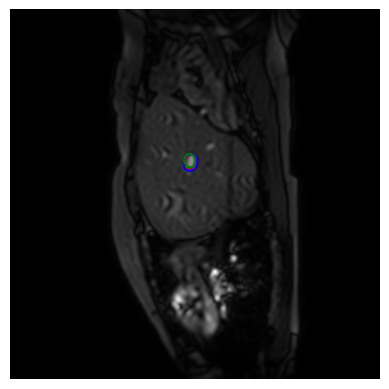

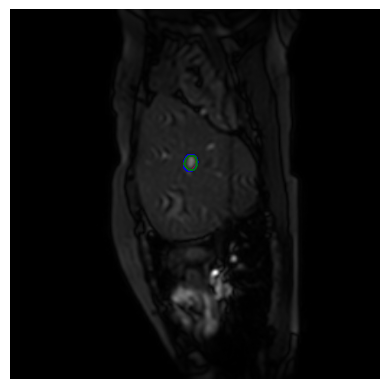

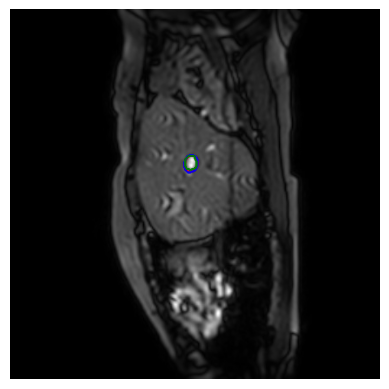

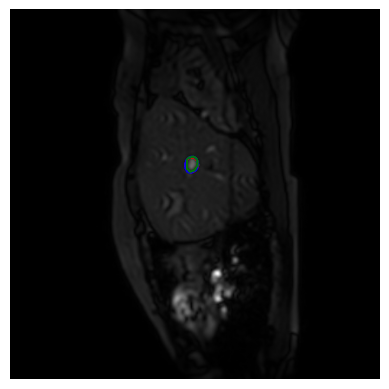

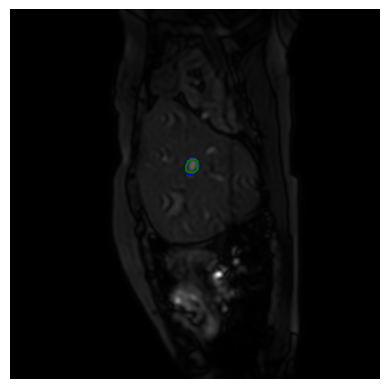

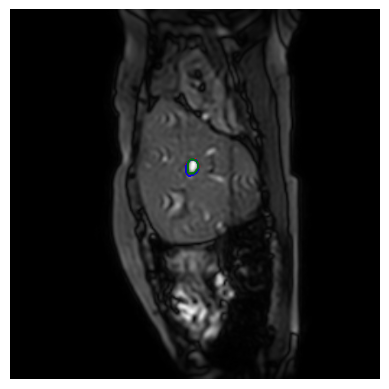

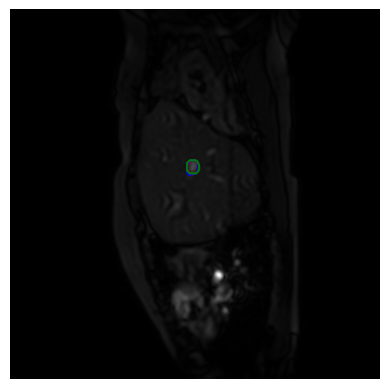

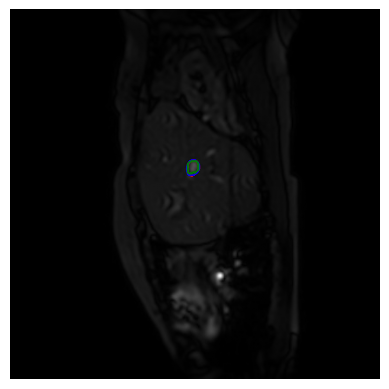

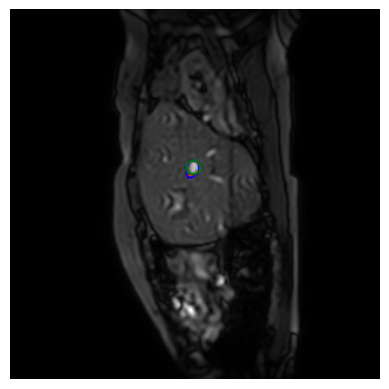

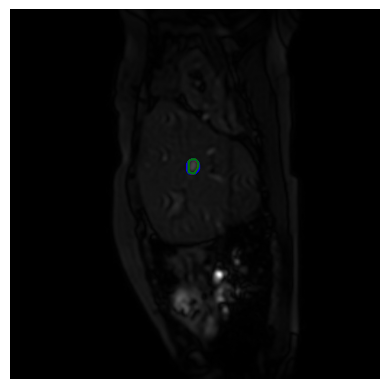

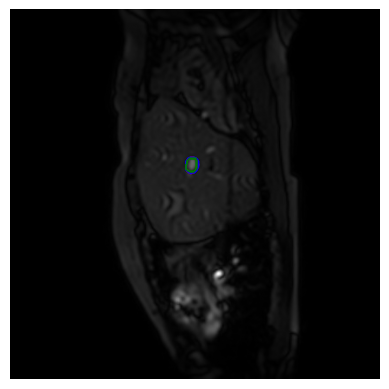

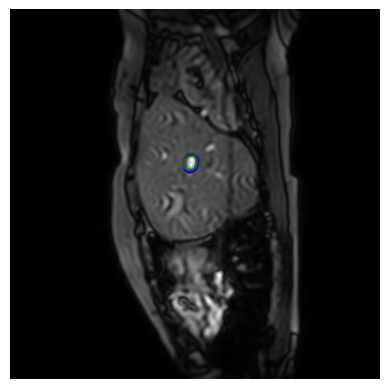

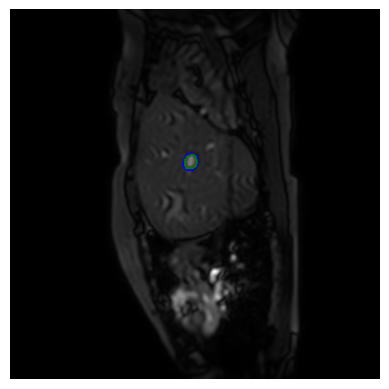

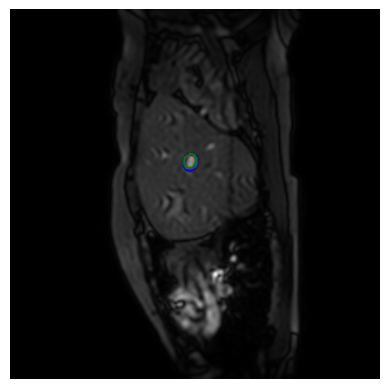

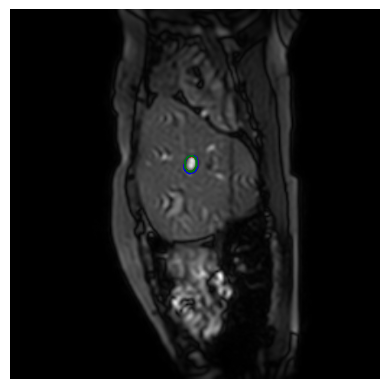

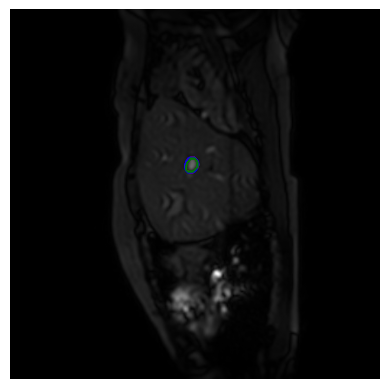

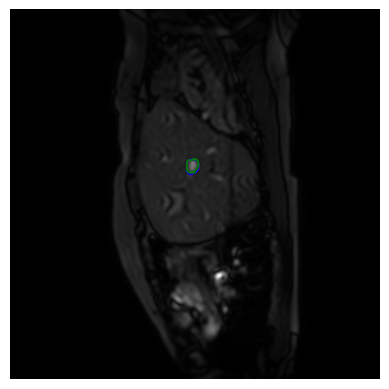

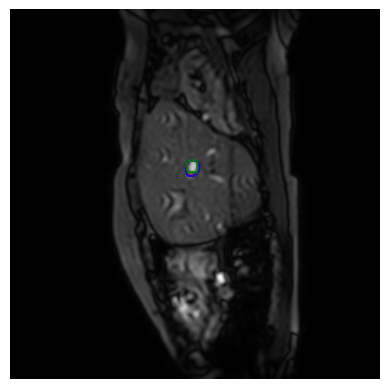

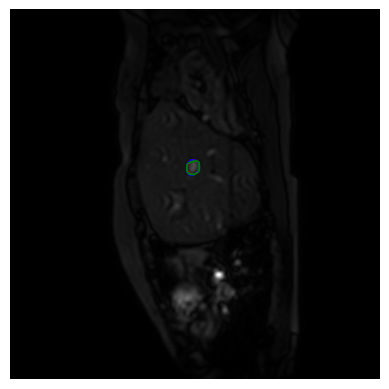

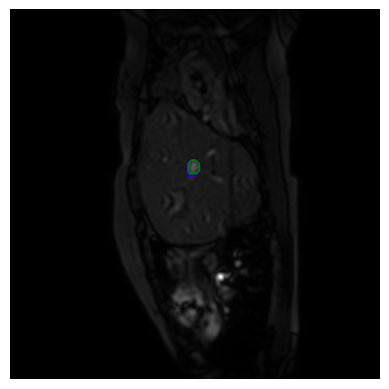

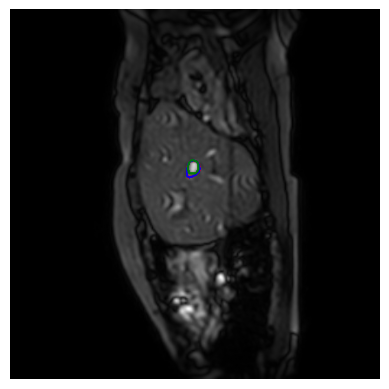

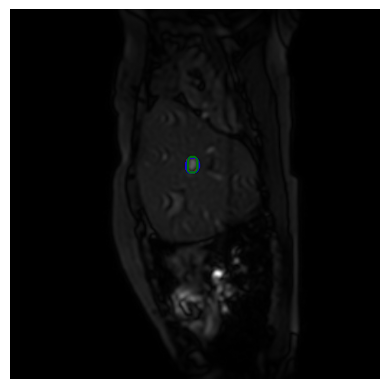

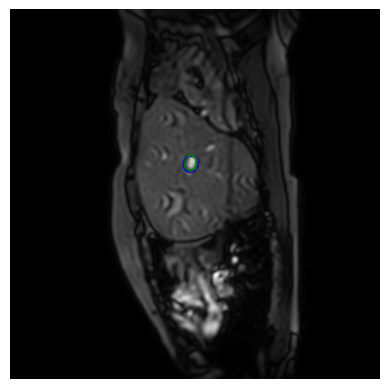

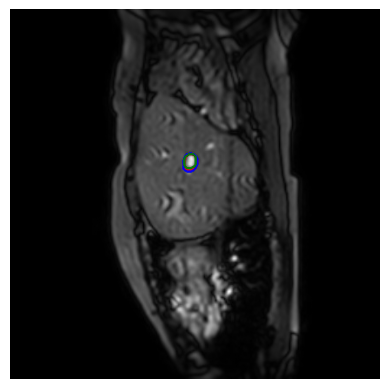

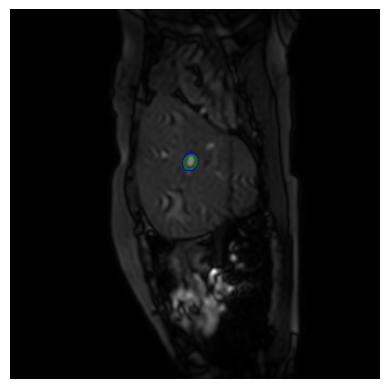

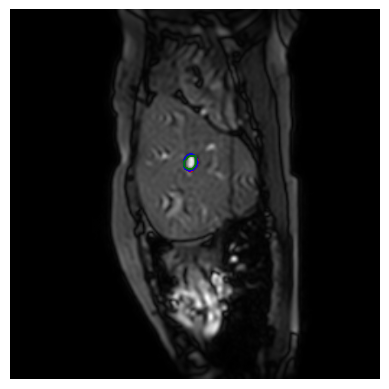

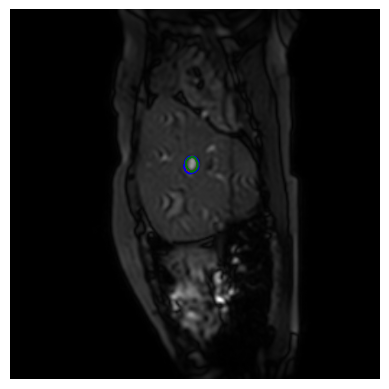

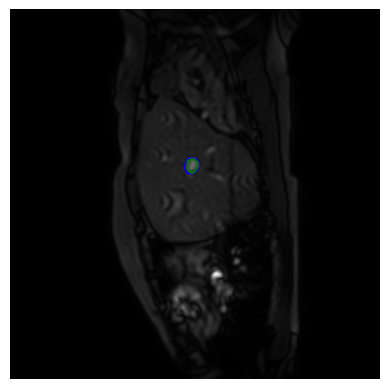

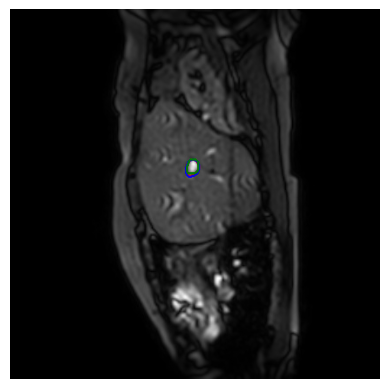

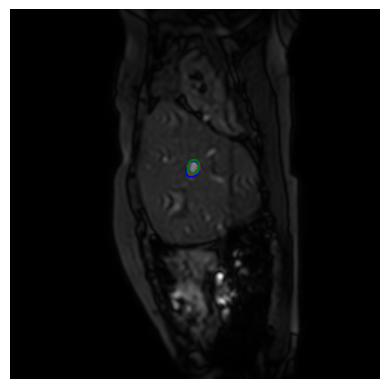

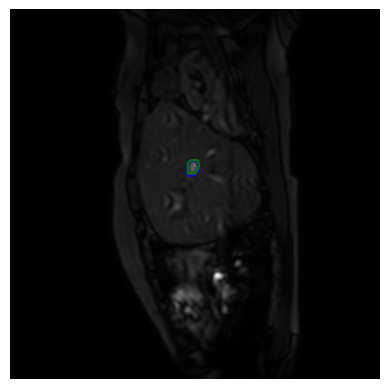

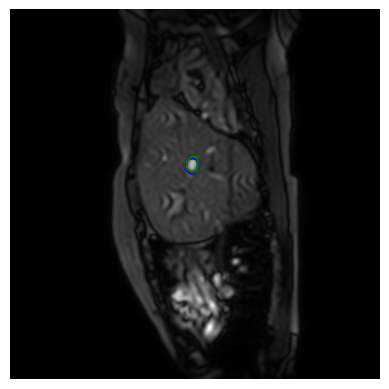

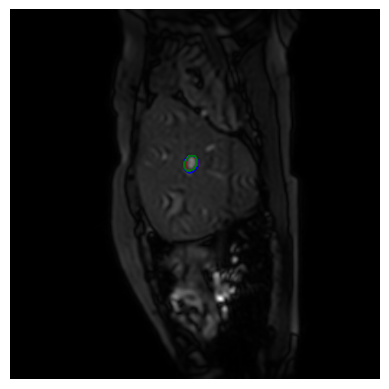

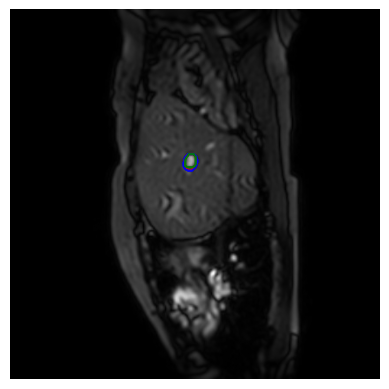

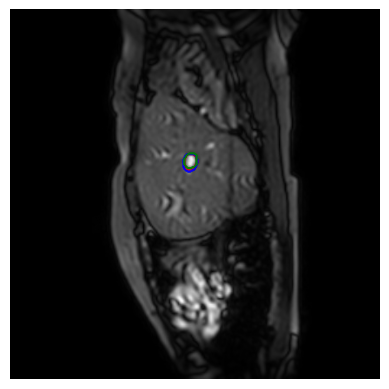

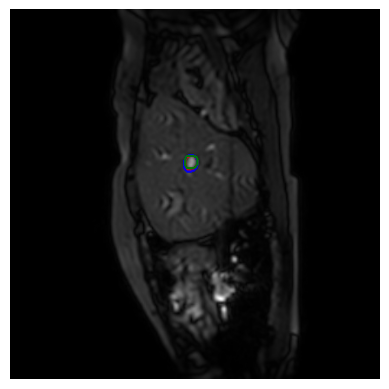

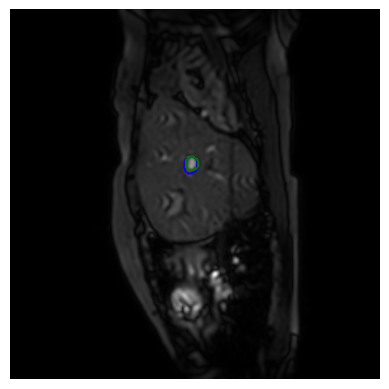

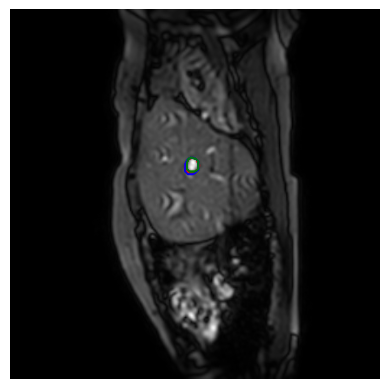

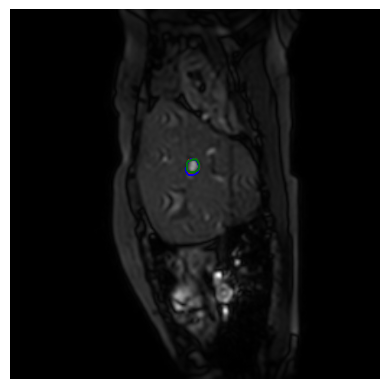

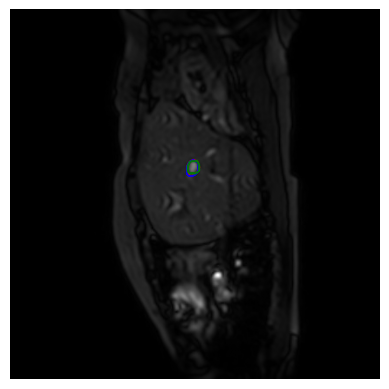

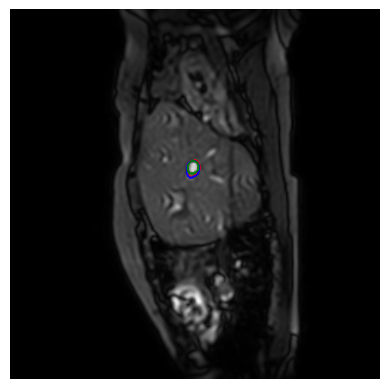

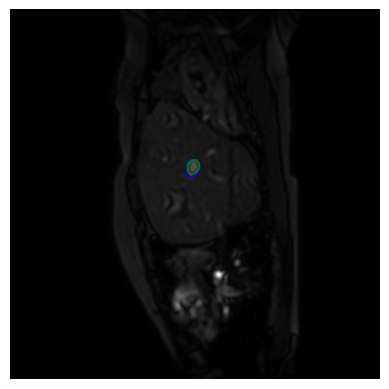

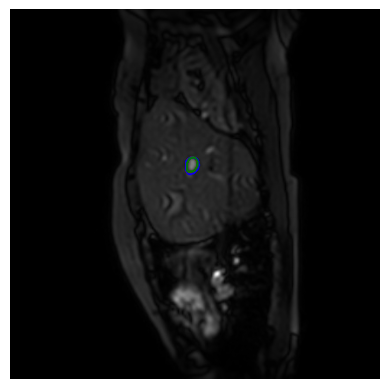

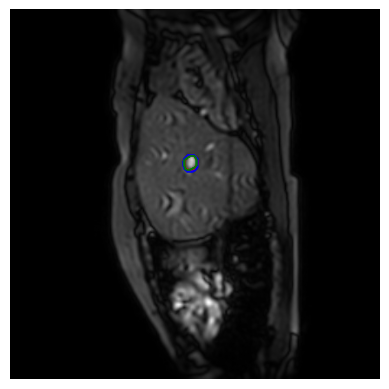

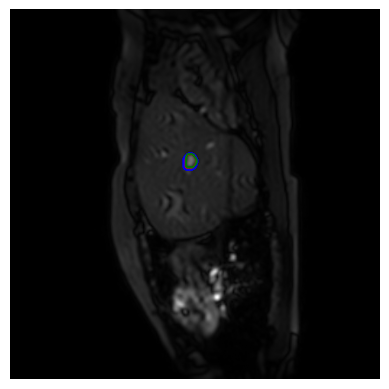

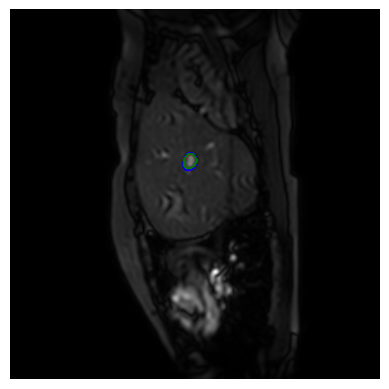

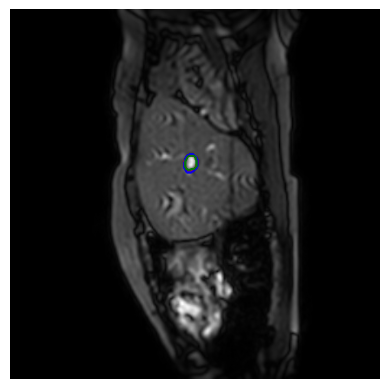

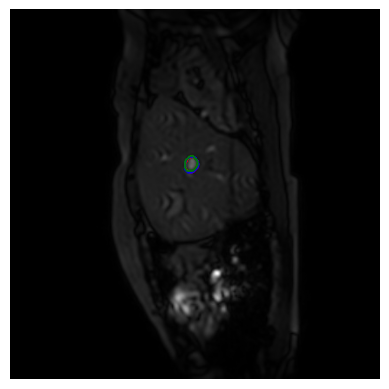

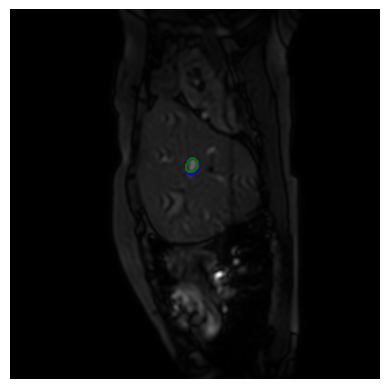

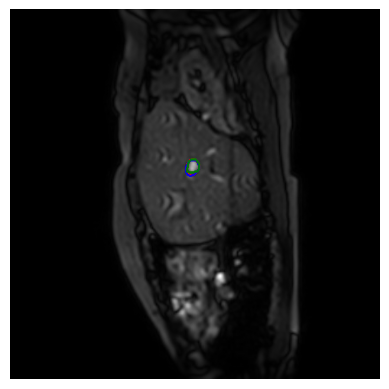

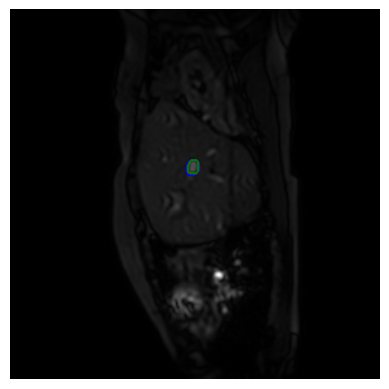

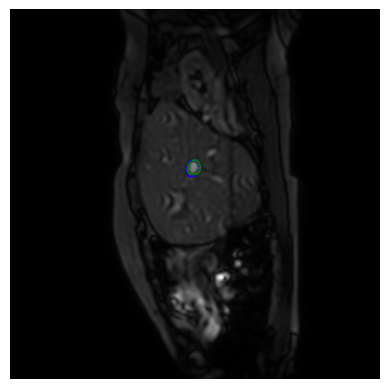

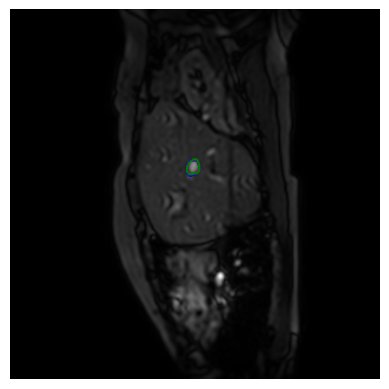

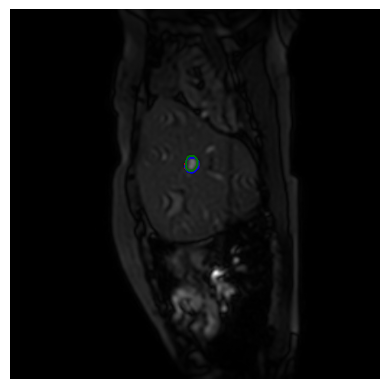

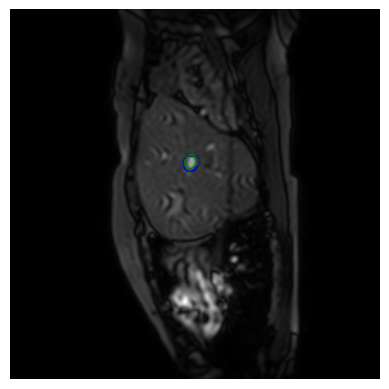

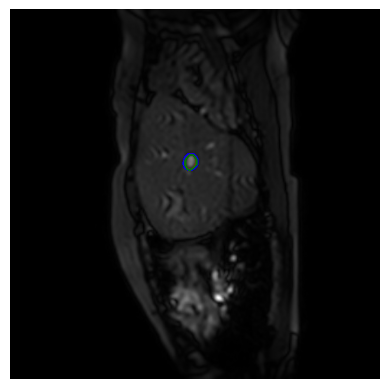

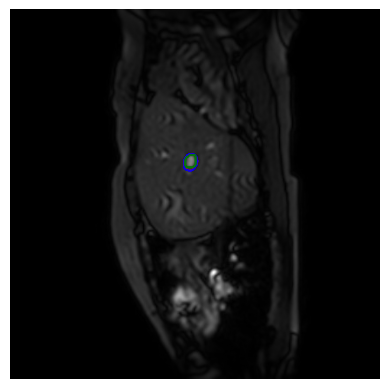

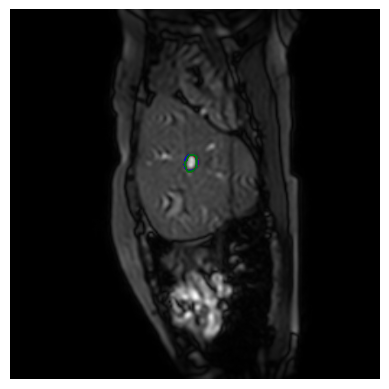

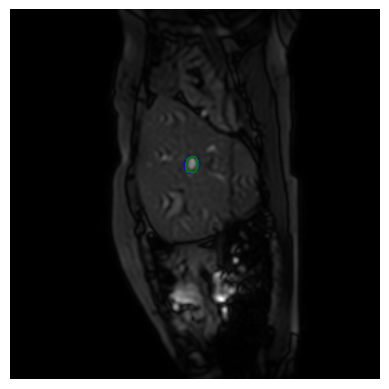

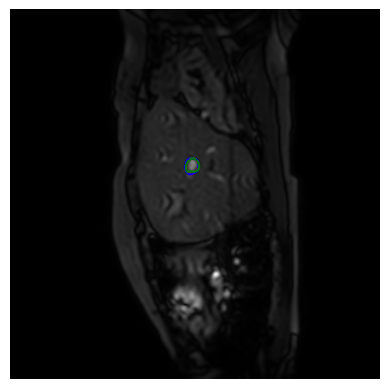

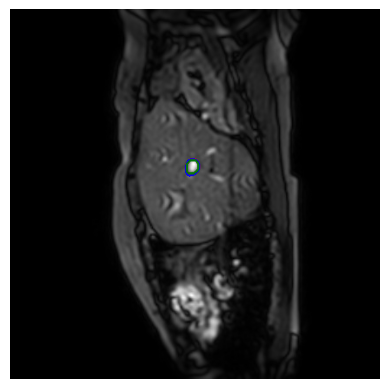

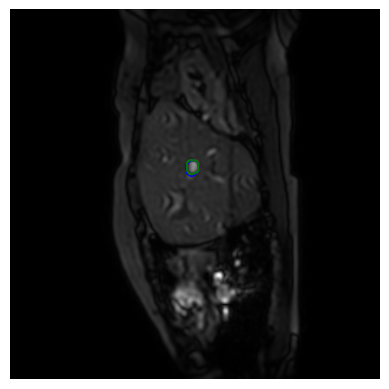

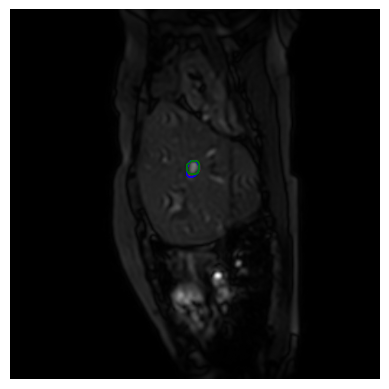

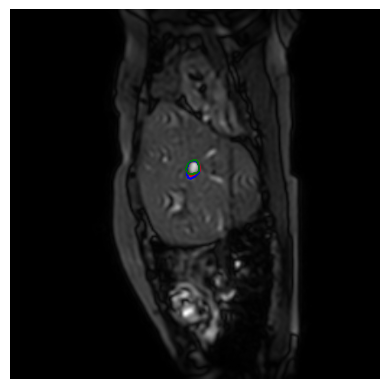

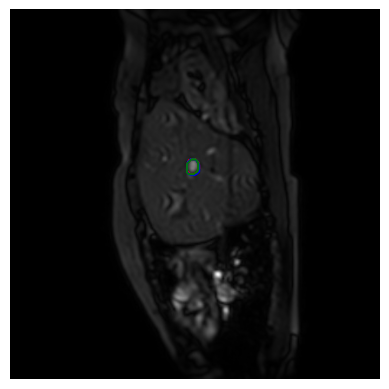

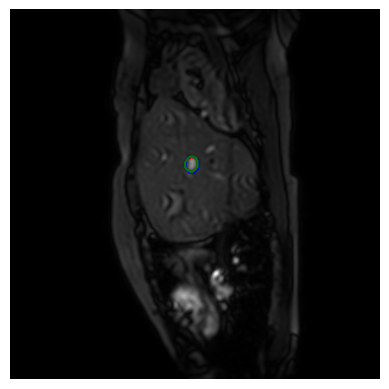

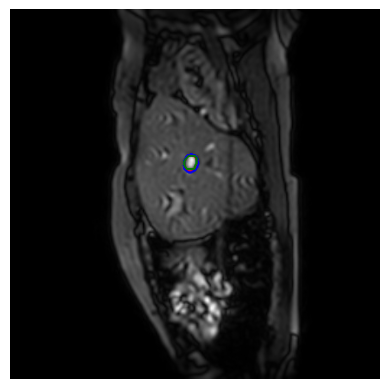

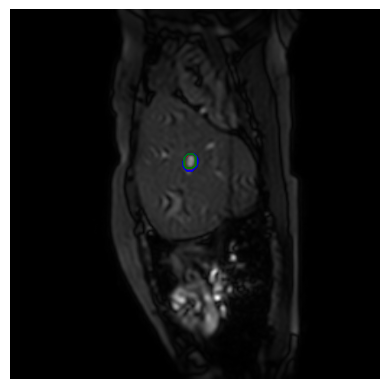

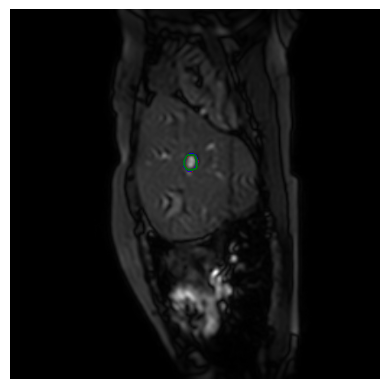

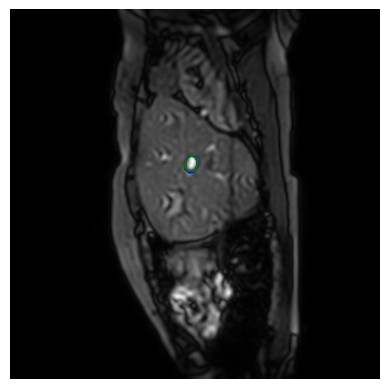

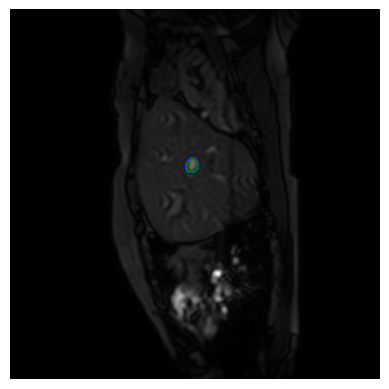

In [9]:
import numpy as np
import SimpleITK
from PIL import Image
from scipy import ndimage

CASE_ID = "B_010"
case_id = CASE_ID or sorted_dice[0][0]  # Use the case with min dice
print(case_id)


images = Path("./tmp") / case_id / "jpegs"
baseline_annotations = Path("./tmp") / "annots/baseline" / case_id / "annotations"
refined_annotations = Path("./tmp") / "annots/refined" / case_id / "annotations"

jpg_files = sorted(list(images.glob("*.jpg")))
baseline_annot_files = sorted(list(baseline_annotations.glob("*.png")))
refined_annot_files = sorted(list(refined_annotations.glob("*.png")))

img_arrays = [np.array(Image.open(jpg_file)) for jpg_file in jpg_files]
baseline_annot_arrays = [
    np.array(Image.open(png_file)) for png_file in baseline_annot_files
]
refined_annot_arrays = [
    np.array(Image.open(png_file)) for png_file in refined_annot_files
]

INPUT_PATH = Path(
    "/rodata/mnradonc_dev/m299164/trackrad/datasets/trackrad2025/trackrad2025_labeled_training_data"
)

ground_truth_arrays = []

label_path = INPUT_PATH / case_id / "targets" / f"{case_id}_labels.mha"
label_image = SimpleITK.ReadImage(label_path)
label_array = SimpleITK.GetArrayFromImage(label_image)

for i in range(label_array.shape[-1]):
    ground_truth_arrays.append(label_array[:, :, i])

for img, baseline_annot, refined_annot, ground_truth in list(
    zip(img_arrays, baseline_annot_arrays, refined_annot_arrays, ground_truth_arrays)
):
    baseline_annot_boundary = (
        baseline_annot ^ ndimage.binary_erosion(baseline_annot)
    ).astype(int)
    refined_annot_boundary = (
        refined_annot ^ ndimage.binary_erosion(refined_annot)
    ).astype(int)
    ground_truth_boundary = (
        ground_truth ^ ndimage.binary_erosion(ground_truth)
    ).astype(int)
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.contour(baseline_annot_boundary, colors="red", linewidths=0.2)
    plt.contour(refined_annot_boundary, colors="blue", linewidths=0.2)
    plt.contour(ground_truth_boundary, colors="green", linewidths=0.2)
    plt.axis("off")
    plt.show()

In [10]:
# for img, annot, ground_truth in list(
#     zip(img_arrays, annot_arrays, ground_truth_arrays)
# )[:20]:
#     annot_boundary = (annot ^ ndimage.binary_erosion(annot)).astype(int)
#     ground_truth_boundary = (
#         ground_truth ^ ndimage.binary_erosion(ground_truth)
#     ).astype(int)
#     plt.figure()
#     plt.imshow(img, cmap="gray")
#     plt.imshow(annot, cmap="jet", alpha=0.5)
#     # plt.imshow(ground_truth, cmap="spring", alpha=0.5)
#     plt.axis("off")
#     plt.show()